In [1]:
import math
import matplotlib.pyplot as plt 
import numpy as np
from sklearn.linear_model import LogisticRegression
import pylab
import sys
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

In [2]:
import sys
sys.path.append("../src")

import utils
from NaCL import NaCL2

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
adult_encoding = [[0, 1, 2, 3, 4],[5, 6, 7, 8, 9, 10, 11, 12, 13],[14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29],[30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45],[46, 47, 48, 49, 50, 51, 52],[53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67],[68, 69, 70, 71, 72, 73],[74, 75, 76, 77, 78],[79, 80],[81, 82, 83, 84, 85],[86, 87, 88, 89, 90],[91, 92, 93, 94, 95],
[96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137]]

# Loading Data

In [5]:
X_train, y_train, X_test, y_test = utils.load_dataset("../data/adult_income", "adult")
X_train.shape

(39072, 138)

In [6]:
%%time
from sklearn.naive_bayes import BernoulliNB
NB = BernoulliNB().fit(X_train, y_train)
print(np.average(NB.predict(X_train) == y_train), np.average(NB.predict(X_test) == y_test))

0.8059479934479934 0.8067158067158067
CPU times: user 282 ms, sys: 303 ms, total: 585 ms
Wall time: 165 ms


### Learning Logistic Regression

In [7]:
clf = LogisticRegression(solver='lbfgs', 
    verbose=True, 
    C = 0.1,
    max_iter=2000, n_jobs=6).fit(X_train, y_train)

np.average(clf.predict(X_test) == y_test), np.average(clf.predict(X_train) == y_train)
W = np.hstack((clf.intercept_[:,None], clf.coef_))[0]

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   1 out of   1 | elapsed:    8.6s finished


### Learning NaCL

In [8]:
%%time

nacl = NaCL2().setup(clf, X_train, y_train)
have_mosek = True # set False if you don't have mosek installed
if have_mosek:
    nacl.solve(solver = 'mosek_conif', verbose=1) 
else:
    nacl.solve(solver = 'cvxopt', verbose=1) 

Using solver 'mosek_conif'
 for 554 free variables
  in 556 posynomial inequalities.
Solving took 0.0883 seconds.
CPU times: user 1.17 s, sys: 467 ms, total: 1.64 s
Wall time: 733 ms


In [9]:
# Sanity Check to compare NaCL results with Logistic Regression
assert(1.0 == np.average( nacl.predict(X_test)  == clf.predict(X_test )))
assert(1.0 == np.average( nacl.predict(X_train) == clf.predict(X_train)))

# Generate Tables

Choose the setting such as how many features missing and how many times to repeat. Then, then last code block uses the results from the experiment to print latex code of the tables shown in the paper.

In [10]:
N = len(adult_encoding)

In [11]:
%%time
from sklearn.metrics import f1_score 

accuracy = lambda x,y: np.mean(x == y)
f1 = lambda x,y: f1_score(x,y.flatten(), average = "weighted")

setting = {
    "repeat": 10, #100
    "k": [i for i in range(0, N, int(0.2*N))],
    "feature_encoding": adult_encoding,
    "prob" : False,
    "function": f1#utils.conditional_likelihood_k
}
data_for_table = utils.run_experiment_k_paper(X_test, y_test, clf, NB, nacl, setting)

Using following function: 
<function <lambda> at 0x7ff83d9538c8>
Possible features to remove: 13
K = 0
	 R = 0
K = 2
	 R = 0
K = 4
	 R = 0
K = 6
	 R = 0
K = 8
	 R = 0
K = 10
	 R = 0
K = 12
	 R = 0
CPU times: user 3min 28s, sys: 2min 10s, total: 5min 39s
Wall time: 59.1 s


In [12]:
row = []
for method in ["min", "max", "mean", "median","ours"]:
    temp = []
    for k in range(1, 5):
        m = np.mean(100*data_for_table[method][k])
        s = np.std(100*data_for_table[method][k])
        temp.append(np.round(m, 1))
        print(method, k*20, m, s)
        
    row.append(temp)

row = np.array(row)  
bold = np.argmax(row, axis=0)
print("")
for i in range(len(row)):
    line = ""
    for j in range(len(row[i])):
        if bold[j] == i or row[i][j] == row[bold[j]][j]:
            line += "\\textbf{" + str(row[i][j]) + "}"
        else:
            line += str(row[i][j])
        
        line += " & "
    print(line)
    

min 20 81.81450018417476 0.19930840352536147
min 40 79.42368790349374 0.4670959241757518
min 60 77.58224349244655 0.4988163866396275
min 80 75.83694483613063 0.3172779162975574
max 20 81.81536548307638 0.19654404260629657
max 40 79.4447479545852 0.4609319028344401
max 60 77.57694004209478 0.4950339384398948
max 80 75.80198340654621 0.33481269328428076
mean 20 82.9747752336001 0.16919871989524654
mean 40 79.82126396387767 0.2535632745796217
mean 60 75.41286219077563 0.2293273297920972
mean 80 70.9258954795847 0.2597199215454319
median 20 82.62892892994417 0.17889476002400573
median 40 79.22863208799748 0.15369175456113646
median 60 74.9343973990615 0.33618271857981347
median 80 70.70740498892069 0.3268970010218496
ours 20 83.5345251926904 0.19321959238699224
ours 40 81.22637978440932 0.21744437319719273
ours 60 77.8572051435184 0.2292697815718435
ours 80 73.65477772845672 0.3022864812459695

81.8 & 79.4 & 77.6 & \textbf{75.8} & 
81.8 & 79.4 & 77.6 & \textbf{75.8} & 
83.0 & 79.8 & 75.4 &

# Missing Data Charts

In [13]:
len(adult_encoding), X_test.shape

(13, (9768, 138))

In [14]:
%%time
setting = {
    "repeat": 10, # 100
    "k": [i for i in range(0, 14, 1)],
    "prob" : True,
    "function": utils.conditional_likelihood_k,
    "feature_encoding": adult_encoding,
}
data_a2 = utils.run_experiment_k_paper(X_test, y_test, clf, NB, nacl, setting)

Using following function: 
<function conditional_likelihood_k at 0x7ff83e1e2400>
Possible features to remove: 13
K = 0
	 R = 0
K = 1
	 R = 0
K = 2
	 R = 0
K = 3
	 R = 0
K = 4
	 R = 0
K = 5
	 R = 0
K = 6
	 R = 0
K = 7
	 R = 0
K = 8
	 R = 0
K = 9
	 R = 0
K = 10
	 R = 0
K = 11
	 R = 0
K = 12
	 R = 0
K = 13
	 R = 0
CPU times: user 4min 25s, sys: 2min 30s, total: 6min 56s
Wall time: 1min 34s


<module 'matplotlib.pyplot' from '/home/pasha/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

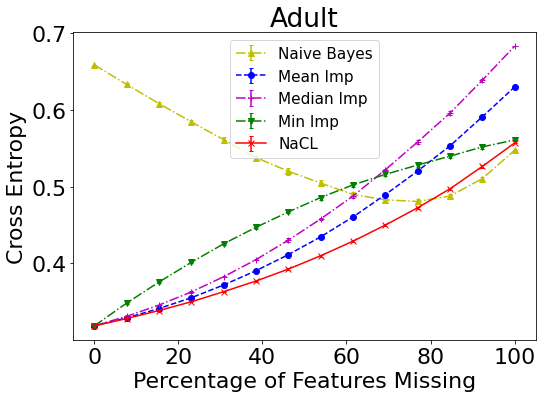

In [15]:
setting = {
    "show": ["min", "mean", "median", "ours", "nb"],
    "saveAs": "../results/adult_cross.pdf",
    "title": "Adult",
    "Ylabel": "Cross Entropy"
}
utils.plot_results_paper(data_a2, setting)

In [16]:
%%time
from sklearn.metrics import f1_score 

accuracy = lambda x,y: np.mean(x == y)
f1 = lambda x,y: f1_score(x,y.flatten(), average = "micro")

setting = {
    "repeat": 10,#100
    "k": [i for i in range(0, 14, 1)],
    "prob" : False,
    "function": f1,
    "feature_encoding": adult_encoding,
}
data_a3 = utils.run_experiment_k_paper(X_test, y_test, clf, NB, nacl, setting)

Using following function: 
<function <lambda> at 0x7ff83d9536a8>
Possible features to remove: 13
K = 0
	 R = 0
K = 1
	 R = 0
K = 2
	 R = 0
K = 3
	 R = 0
K = 4
	 R = 0
K = 5
	 R = 0
K = 6
	 R = 0
K = 7
	 R = 0
K = 8
	 R = 0
K = 9
	 R = 0
K = 10
	 R = 0
K = 11
	 R = 0
K = 12
	 R = 0
K = 13
	 R = 0
CPU times: user 6min 55s, sys: 4min 12s, total: 11min 8s
Wall time: 2min 14s


<module 'matplotlib.pyplot' from '/home/pasha/.local/lib/python3.6/site-packages/matplotlib/pyplot.py'>

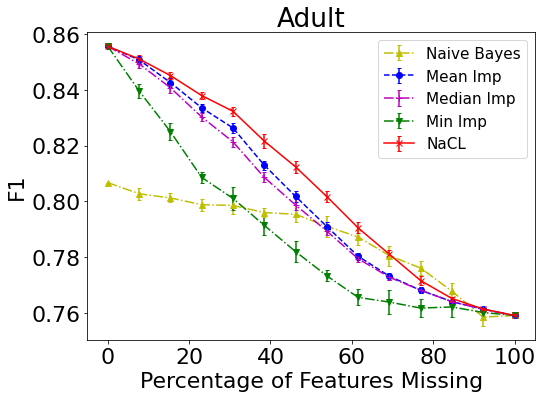

In [17]:
setting = {
    "show": ["min", "ours", "mean", "median", "nb"],
    "saveAs": "../results/adult_accuracy.pdf",
    "title": "Adult",
    "Ylabel": "F1"
}
utils.plot_results_paper(data_a3, setting)

In [18]:
utils.save("../results/data_adult_result_cross.pickle", data_a2)
utils.save("../results/data_adult_result_accuracy.pickle", data_a3)